# EDA Completo - Predicción de Riesgo de ACV (NHANES Dataset)

## Análisis Exploratorio de Datos Robusto

Este notebook contiene un análisis exploratorio completo del dataset NHANES para la predicción de riesgo de accidente cerebrovascular (stroke).

**Objetivos:**
- Entender la estructura y calidad de los datos
- Identificar patrones y relaciones entre variables
- Detectar problemas de datos (valores faltantes, outliers, desbalance)
- Generar insights para el preprocesamiento y modelado


## 1. Carga y Configuración Inicial


In [1]:
# Importar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy import stats
from scipy.stats import chi2_contingency
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Configuración de pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Semilla aleatoria para reproducibilidad
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("✓ Librerías importadas y configuración establecida")


✓ Librerías importadas y configuración establecida


In [2]:
# Definir rutas de datos
from pathlib import Path

PROJECT_ROOT = Path().resolve().parent.parent
DATA_RAW = PROJECT_ROOT / "ml_models" / "data" / "raw" / "nhanes_stroke_raw.csv"
DATA_PROCESSED = PROJECT_ROOT / "ml_models" / "data" / "processed" / "nhanes_stroke_clean.csv"

# Cargar datos crudos
print("Cargando datos crudos...")
df_raw = pd.read_csv(DATA_RAW)
print(f"✓ Datos crudos cargados: {df_raw.shape}")

# Cargar datos procesados (si existe)
if DATA_PROCESSED.exists():
    print("Cargando datos procesados...")
    df_processed = pd.read_csv(DATA_PROCESSED)
    print(f"✓ Datos procesados cargados: {df_processed.shape}")
else:
    df_processed = None
    print("⚠ Datos procesados no encontrados")

# Trabajaremos principalmente con datos crudos para el EDA
df = df_raw.copy()
print(f"\nDataset principal: {df.shape[0]} filas, {df.shape[1]} columnas")


Cargando datos crudos...
✓ Datos crudos cargados: (4603, 36)
Cargando datos procesados...
✓ Datos procesados cargados: (4603, 31)

Dataset principal: 4603 filas, 36 columnas


## 2. Análisis de Calidad de Datos


In [3]:
# Información general del dataset
print("=" * 60)
print("INFORMACIÓN GENERAL DEL DATASET")
print("=" * 60)
print(f"\nDimensiones: {df.shape[0]} filas × {df.shape[1]} columnas")
print(f"\nTipos de datos:")
print(df.dtypes.value_counts())
print(f"\nPrimeras filas:")
df.head()


INFORMACIÓN GENERAL DEL DATASET

Dimensiones: 4603 filas × 36 columnas

Tipos de datos:
int64      22
float64    14
Name: count, dtype: int64

Primeras filas:


,stroke,gender,age,Race,Marital status,alcohol,smoke,sleep disorder,Health Insurance,General health condition,depression,sleep time,diabetes,hypertension,high cholesterol,Minutes sedentary activity,Coronary Heart Disease,Body Mass Index,Waist Circumference,Systolic blood pressure,Diastolic blood pressure,High-density lipoprotein,Triglyceride,Low-density lipoprotein,Fasting Glucose,Glycohemoglobin,energy,protein,Carbohydrate,Dietary fiber,Total fat,Total saturated fatty acids,Total monounsaturated fatty acids,Total polyunsaturated fatty acids,Potassium,Sodium
0,0,2,2,5,1,0,0,2,2,3,1,6.000,0,1,0,720,0,4,156.300,128,64,1.220,1.804,2.633,7.791,5.700,1598,62.780,192.190,10.000,65.640,25.112,24.090,8.543,2887,2969
1,0,2,2,1,1,0,0,1,2,3,1,5.000,0,1,1,480,0,4,97.000,126,64,0.960,2.631,2.845,6.828,6.100,1547,45.350,256.020,17.000,42.560,13.423,15.389,10.613,2058,2091
2,1,1,2,3,1,1,1,2,1,3,1,8.000,0,1,1,600,0,2,95.000,148,88,1.730,1.396,2.576,6.973,5.200,2466,81.560,254.490,13.000,103.320,43.295,36.727,15.366,3117,5233
3,0,2,3,3,1,1,1,2,1,4,2,6.000,1,0,1,720,0,4,126.400,124,68,0.930,5.803,3.069,23.425,5.800,1605,70.990,143.370,10.000,81.600,24.527,30.567,18.174,1766,3706
4,0,1,1,4,1,0,0,2,1,2,1,4.000,0,0,0,240,0,4,104.200,124,80,0.780,2.300,3.827,6.999,5.700,1818,74.750,229.450,14.200,67.490,26.030,24.837,10.533,1842,2461


In [4]:
# Análisis de valores faltantes
missing_data = pd.DataFrame({
    'Columna': df.columns,
    'Valores_Faltantes': df.isnull().sum(),
    'Porcentaje': (df.isnull().sum() / len(df)) * 100
}).sort_values('Porcentaje', ascending=False)

print("=" * 60)
print("ANÁLISIS DE VALORES FALTANTES")
print("=" * 60)
print(f"\nTotal de valores faltantes: {df.isnull().sum().sum()}")
print(f"Columnas con valores faltantes: {(missing_data['Valores_Faltantes'] > 0).sum()}")
print("\nTop 10 columnas con más valores faltantes:")
print(missing_data[missing_data['Valores_Faltantes'] > 0].head(10))

# Visualización de valores faltantes
if missing_data['Valores_Faltantes'].sum() > 0:
    plt.figure(figsize=(12, 6))
    missing_plot = missing_data[missing_data['Valores_Faltantes'] > 0]
    plt.barh(missing_plot['Columna'], missing_plot['Porcentaje'])
    plt.xlabel('Porcentaje de Valores Faltantes (%)')
    plt.title('Distribución de Valores Faltantes por Columna')
    plt.tight_layout()
    plt.show()
else:
    print("\n✓ No hay valores faltantes en el dataset")


ANÁLISIS DE VALORES FALTANTES

Total de valores faltantes: 0
Columnas con valores faltantes: 0

Top 10 columnas con más valores faltantes:
Empty DataFrame
Columns: [Columna, Valores_Faltantes, Porcentaje]
Index: []

✓ No hay valores faltantes en el dataset


In [5]:
# Verificar duplicados
duplicados = df.duplicated().sum()
print("=" * 60)
print("ANÁLISIS DE DUPLICADOS")
print("=" * 60)
print(f"Filas duplicadas: {duplicados}")
print(f"Porcentaje de duplicados: {(duplicados / len(df)) * 100:.2f}%")

if duplicados > 0:
    print("\n⚠ Se encontraron filas duplicadas que deberían ser eliminadas")
else:
    print("\n✓ No hay filas duplicadas")


ANÁLISIS DE DUPLICADOS
Filas duplicadas: 0
Porcentaje de duplicados: 0.00%

✓ No hay filas duplicadas


In [6]:
# Identificar tipos de variables
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

# Si hay columnas que parecen categóricas pero son numéricas
# (valores enteros con pocos valores únicos)
potential_categorical = []
for col in numeric_cols:
    if df[col].nunique() < 20 and df[col].dtype in ['int64', 'int32']:
        potential_categorical.append(col)

print("=" * 60)
print("CLASIFICACIÓN DE VARIABLES")
print("=" * 60)
print(f"\nVariables numéricas: {len(numeric_cols)}")
print(f"Variables categóricas (objeto): {len(categorical_cols)}")
print(f"Variables numéricas que podrían ser categóricas: {len(potential_categorical)}")
print(f"\nVariables potencialmente categóricas:")
print(potential_categorical)

# Separar target
target_col = 'stroke' if 'stroke' in df.columns else None
if target_col:
    if target_col in numeric_cols:
        numeric_cols.remove(target_col)
    if target_col in potential_categorical:
        potential_categorical.remove(target_col)


CLASIFICACIÓN DE VARIABLES

Variables numéricas: 36
Variables categóricas (objeto): 0
Variables numéricas que podrían ser categóricas: 16

Variables potencialmente categóricas:
['stroke', 'gender', 'age', 'Race', 'Marital status', 'alcohol ', 'smoke', 'sleep disorder', 'Health Insurance', 'General health condition', 'depression', 'diabetes', 'hypertension', 'high cholesterol', 'Coronary Heart Disease', 'Body Mass Index']


## 3. Análisis Univariado


DISTRIBUCIÓN DE LA VARIABLE TARGET (STROKE)

Conteo:
  0: 4241 (92.14%)
  1: 362 (7.86%)


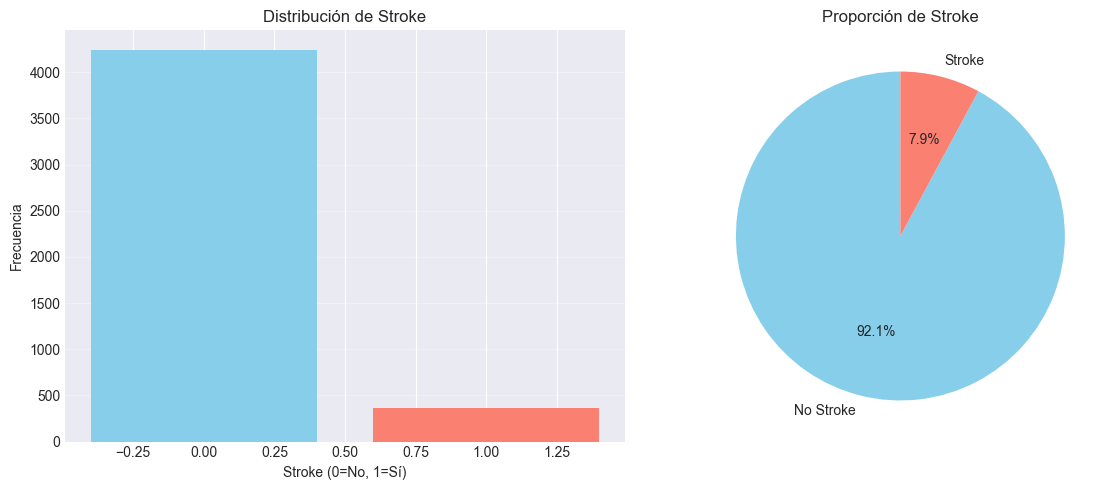


Ratio de desbalance: 11.72:1
⚠ Dataset desbalanceado - se requerirán técnicas de balanceo


In [7]:
# Distribución de la variable target
if target_col:
    print("=" * 60)
    print("DISTRIBUCIÓN DE LA VARIABLE TARGET (STROKE)")
    print("=" * 60)
    
    target_dist = df[target_col].value_counts().sort_index()
    target_pct = df[target_col].value_counts(normalize=True).sort_index() * 100
    
    print(f"\nConteo:")
    for val, count in target_dist.items():
        print(f"  {val}: {count} ({target_pct[val]:.2f}%)")
    
    # Visualización
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Gráfico de barras
    axes[0].bar(target_dist.index, target_dist.values, color=['skyblue', 'salmon'])
    axes[0].set_xlabel('Stroke (0=No, 1=Sí)')
    axes[0].set_ylabel('Frecuencia')
    axes[0].set_title('Distribución de Stroke')
    axes[0].grid(axis='y', alpha=0.3)
    
    # Gráfico de pastel
    axes[1].pie(target_dist.values, labels=['No Stroke', 'Stroke'], 
                autopct='%1.1f%%', colors=['skyblue', 'salmon'], startangle=90)
    axes[1].set_title('Proporción de Stroke')
    
    plt.tight_layout()
    plt.show()
    
    # Análisis de desbalance
    imbalance_ratio = target_dist[0] / target_dist[1] if len(target_dist) > 1 else 1
    print(f"\nRatio de desbalance: {imbalance_ratio:.2f}:1")
    if imbalance_ratio > 2 or imbalance_ratio < 0.5:
        print("⚠ Dataset desbalanceado - se requerirán técnicas de balanceo")
    else:
        print("✓ Dataset relativamente balanceado")


In [8]:
# Estadísticas descriptivas de variables numéricas
print("=" * 60)
print("ESTADÍSTICAS DESCRIPTIVAS - VARIABLES NUMÉRICAS")
print("=" * 60)
print(df[numeric_cols].describe().T)


ESTADÍSTICAS DESCRIPTIVAS - VARIABLES NUMÉRICAS
                                     count     mean      std    min      25%  \
gender                            4603.000    1.545    0.498  1.000    1.000   
age                               4603.000    2.245    0.663  1.000    2.000   
Race                              4603.000    3.067    1.040  1.000    3.000   
Marital status                    4603.000    2.277    1.634  1.000    1.000   
alcohol                           4603.000    0.727    0.446  0.000    0.000   
smoke                             4603.000    0.522    0.500  0.000    0.000   
sleep disorder                    4603.000    1.752    0.432  1.000    2.000   
Health Insurance                  4603.000    1.129    0.335  1.000    1.000   
General health condition          4603.000    3.208    0.929  1.000    3.000   
depression                        4603.000    1.225    0.554  1.000    1.000   
sleep time                        4603.000    6.945    1.648  1.000    6

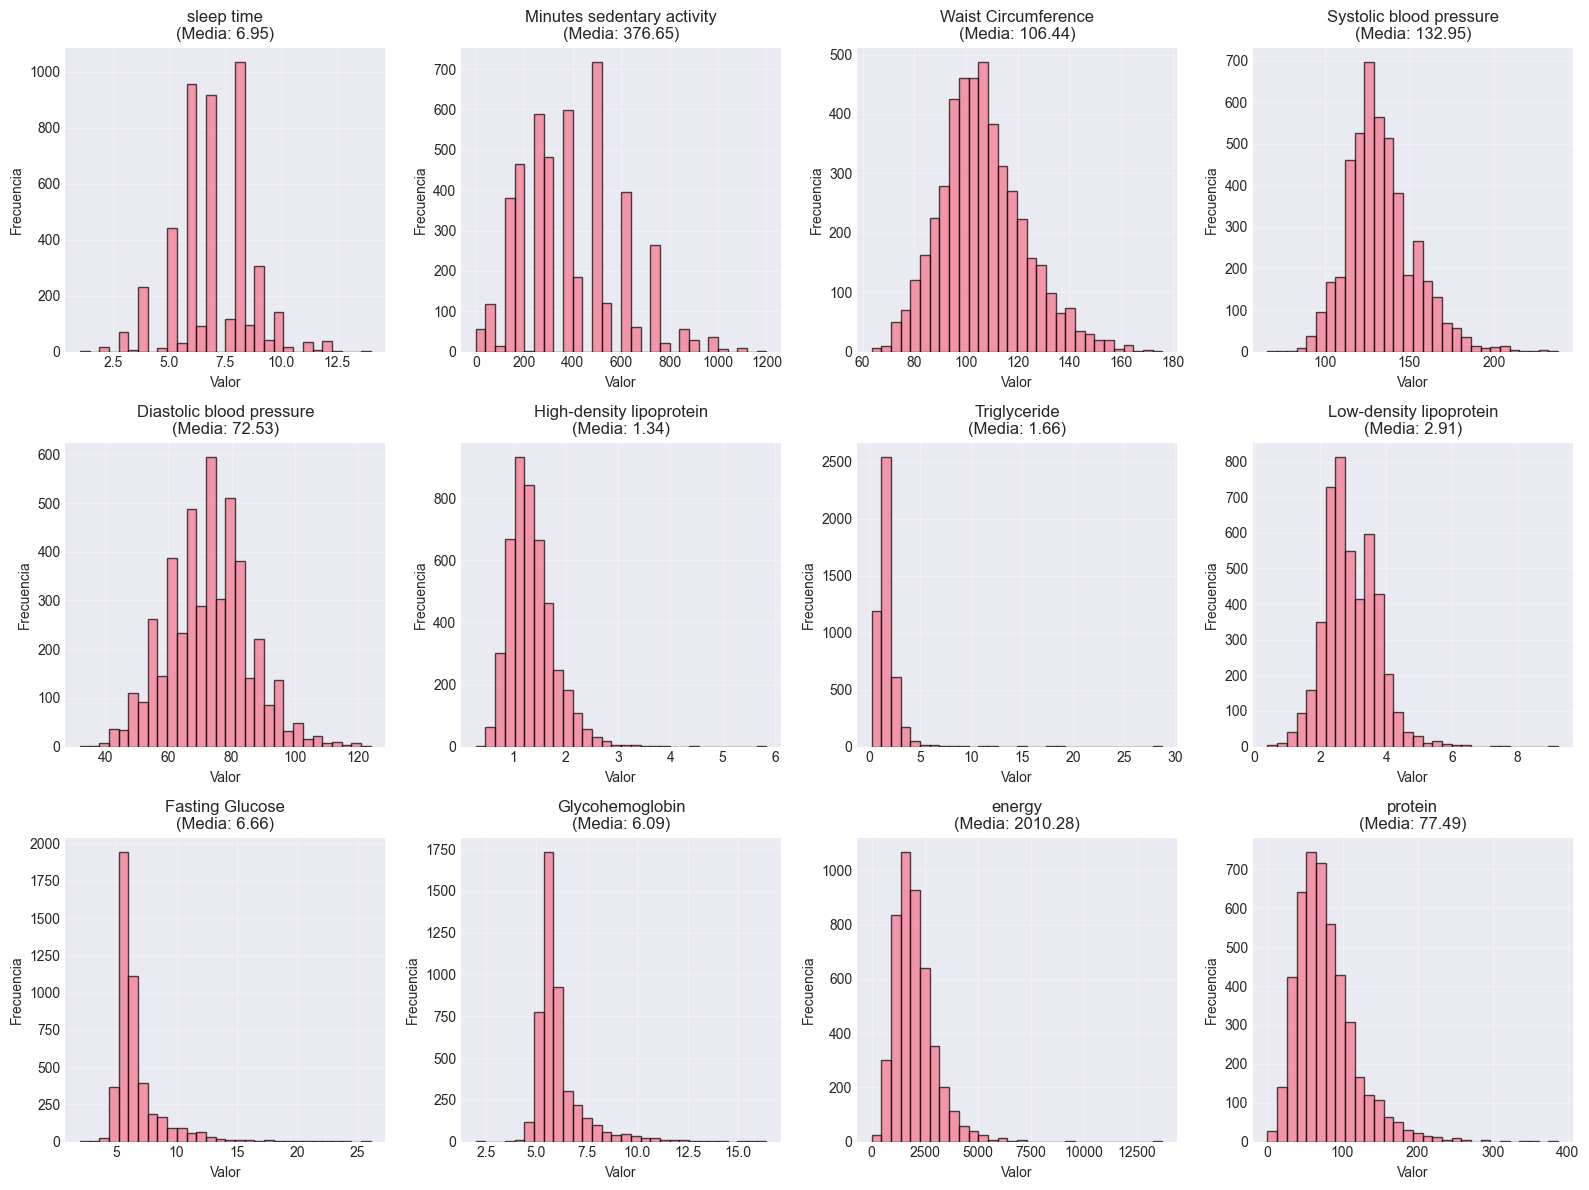

In [9]:
# Visualización de distribuciones de variables numéricas clave
# Seleccionar algunas variables importantes para visualizar
key_numeric = [col for col in numeric_cols if col not in potential_categorical][:12]

if len(key_numeric) > 0:
    n_cols = 4
    n_rows = (len(key_numeric) + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4*n_rows))
    axes = axes.flatten()
    
    for idx, col in enumerate(key_numeric):
        axes[idx].hist(df[col].dropna(), bins=30, edgecolor='black', alpha=0.7)
        axes[idx].set_title(f'{col}\n(Media: {df[col].mean():.2f})')
        axes[idx].set_xlabel('Valor')
        axes[idx].set_ylabel('Frecuencia')
        axes[idx].grid(alpha=0.3)
    
    # Ocultar ejes vacíos
    for idx in range(len(key_numeric), len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()


DETECCIÓN DE OUTLIERS (Método IQR)

Variables con outliers detectados:
                         Variable  Outliers  Porcentaje       Q1       Q3      IQR
                  Fasting Glucose       532      11.558    5.613    6.828    1.215
                  Glycohemoglobin       410       8.907    5.400    6.300    0.900
                     Triglyceride       268       5.822    1.143    1.909    0.766
                          protein       173       3.758   50.240   95.455   45.215
Total polyunsaturated fatty acids       170       3.693    9.556   23.268   13.712
                    Dietary fiber       170       3.693    9.300   20.500   11.200
      Total saturated fatty acids       154       3.346   14.148   32.332   18.184
                           Sodium       150       3.259 2154.500 4178.000 2023.500
Total monounsaturated fatty acids       146       3.172   16.138   35.819   19.681
                     Carbohydrate       145       3.150  160.380  296.295  135.915


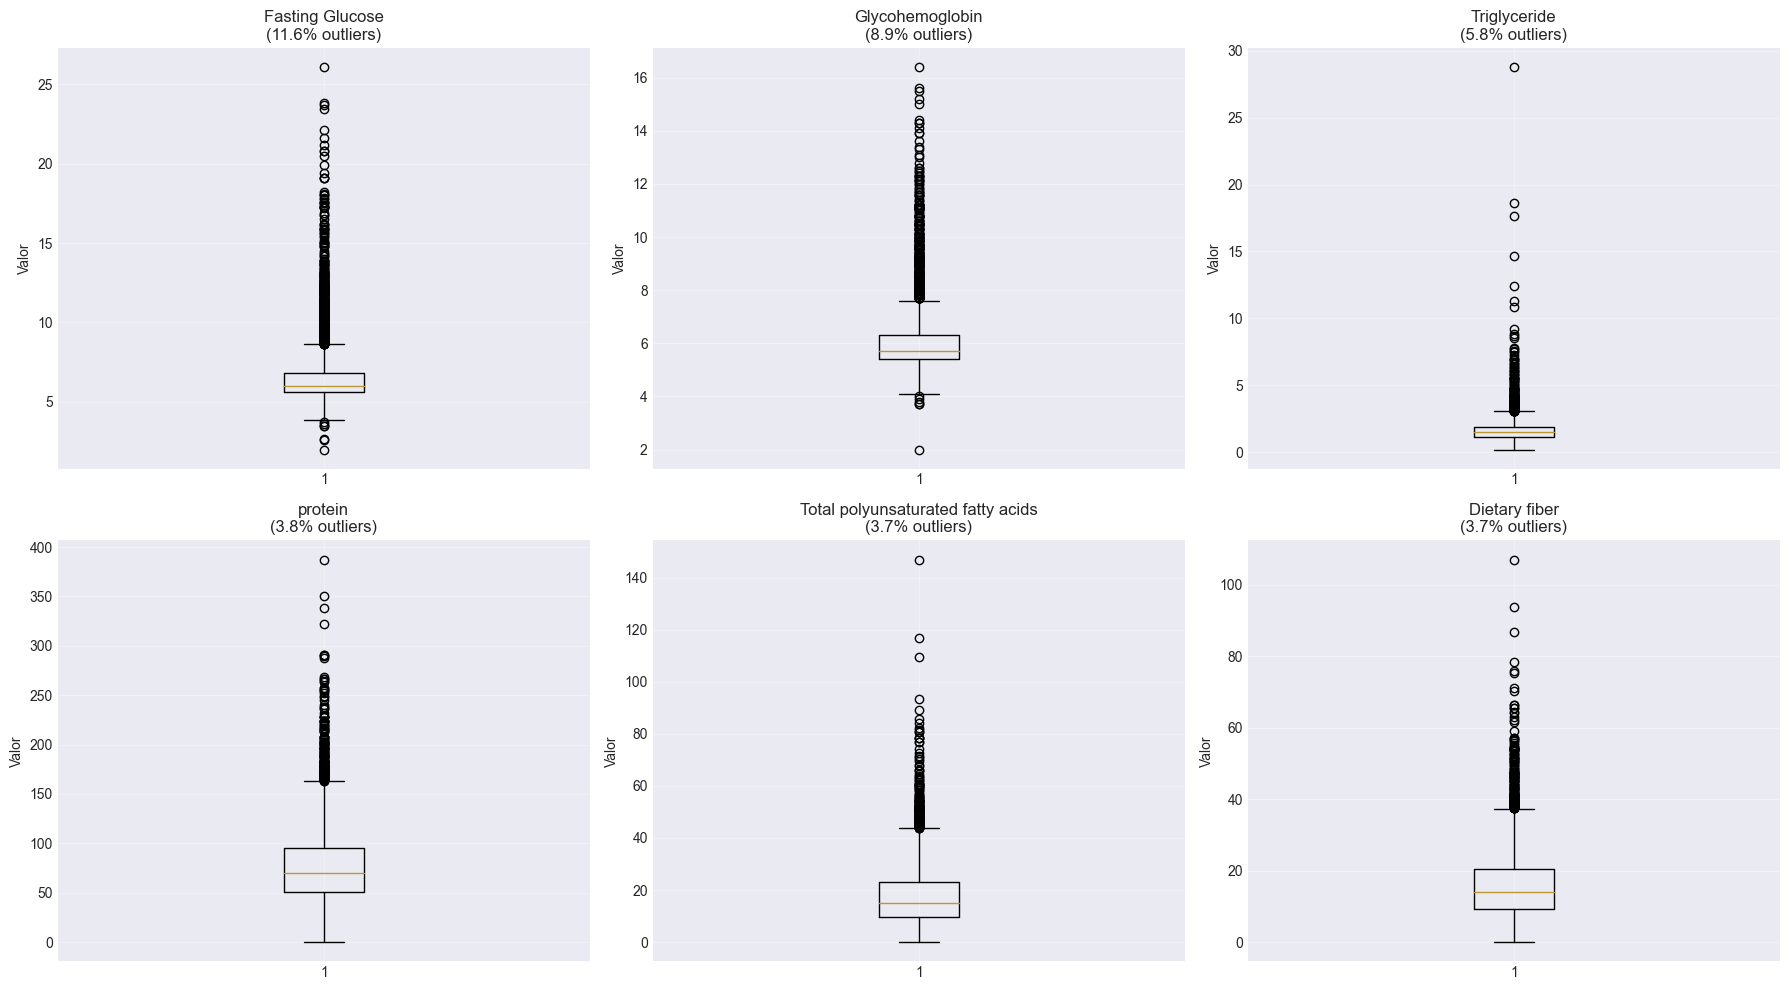

In [10]:
# Detección de outliers usando IQR
print("=" * 60)
print("DETECCIÓN DE OUTLIERS (Método IQR)")
print("=" * 60)

outliers_summary = []
for col in numeric_cols:
    if col not in potential_categorical:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = ((df[col] < lower_bound) | (df[col] > upper_bound)).sum()
        outliers_pct = (outliers / len(df)) * 100
        
        if outliers > 0:
            outliers_summary.append({
                'Variable': col,
                'Outliers': outliers,
                'Porcentaje': outliers_pct,
                'Q1': Q1,
                'Q3': Q3,
                'IQR': IQR
            })

if outliers_summary:
    outliers_df = pd.DataFrame(outliers_summary).sort_values('Porcentaje', ascending=False)
    print(f"\nVariables con outliers detectados:")
    print(outliers_df.head(10).to_string(index=False))
    
    # Visualización de outliers en variables más afectadas
    top_outliers = outliers_df.head(6)['Variable'].tolist()
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()
    
    for idx, col in enumerate(top_outliers):
        axes[idx].boxplot(df[col].dropna())
        axes[idx].set_title(f'{col}\n({outliers_df[outliers_df["Variable"]==col]["Porcentaje"].values[0]:.1f}% outliers)')
        axes[idx].set_ylabel('Valor')
        axes[idx].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("\n✓ No se detectaron outliers significativos")


In [11]:
# Distribución de variables categóricas
print("=" * 60)
print("DISTRIBUCIÓN DE VARIABLES CATEGÓRICAS")
print("=" * 60)

categorical_vars = categorical_cols + potential_categorical
if target_col and target_col in categorical_vars:
    categorical_vars.remove(target_col)

for col in categorical_vars[:10]:  # Mostrar primeras 10
    print(f"\n{col}:")
    value_counts = df[col].value_counts()
    print(value_counts.head(10))
    print(f"Valores únicos: {df[col].nunique()}")


DISTRIBUCIÓN DE VARIABLES CATEGÓRICAS

gender:
gender
2    2510
1    2093
Name: count, dtype: int64
Valores únicos: 2

age:
age
2    2304
3    1713
1     586
Name: count, dtype: int64
Valores únicos: 3

Race:
Race
3    2192
4    1101
1     518
2     447
5     345
Name: count, dtype: int64
Valores únicos: 5

Marital status:
Marital status
1    2373
3     690
2     580
5     501
6     269
4     190
Name: count, dtype: int64
Valores únicos: 6

alcohol :
alcohol 
1    3346
0    1257
Name: count, dtype: int64
Valores únicos: 2

smoke:
smoke
1    2402
0    2201
Name: count, dtype: int64
Valores únicos: 2

sleep disorder:
sleep disorder
2    3462
1    1141
Name: count, dtype: int64
Valores únicos: 2

Health Insurance:
Health Insurance
1    4010
2     593
Name: count, dtype: int64
Valores únicos: 2

General health condition:
General health condition
3    1894
4    1394
2     828
5     341
1     146
Name: count, dtype: int64
Valores únicos: 5

depression:
depression
1    3872
2     426
3     30

## 4. Análisis Bivariado


MATRIZ DE CORRELACIÓN


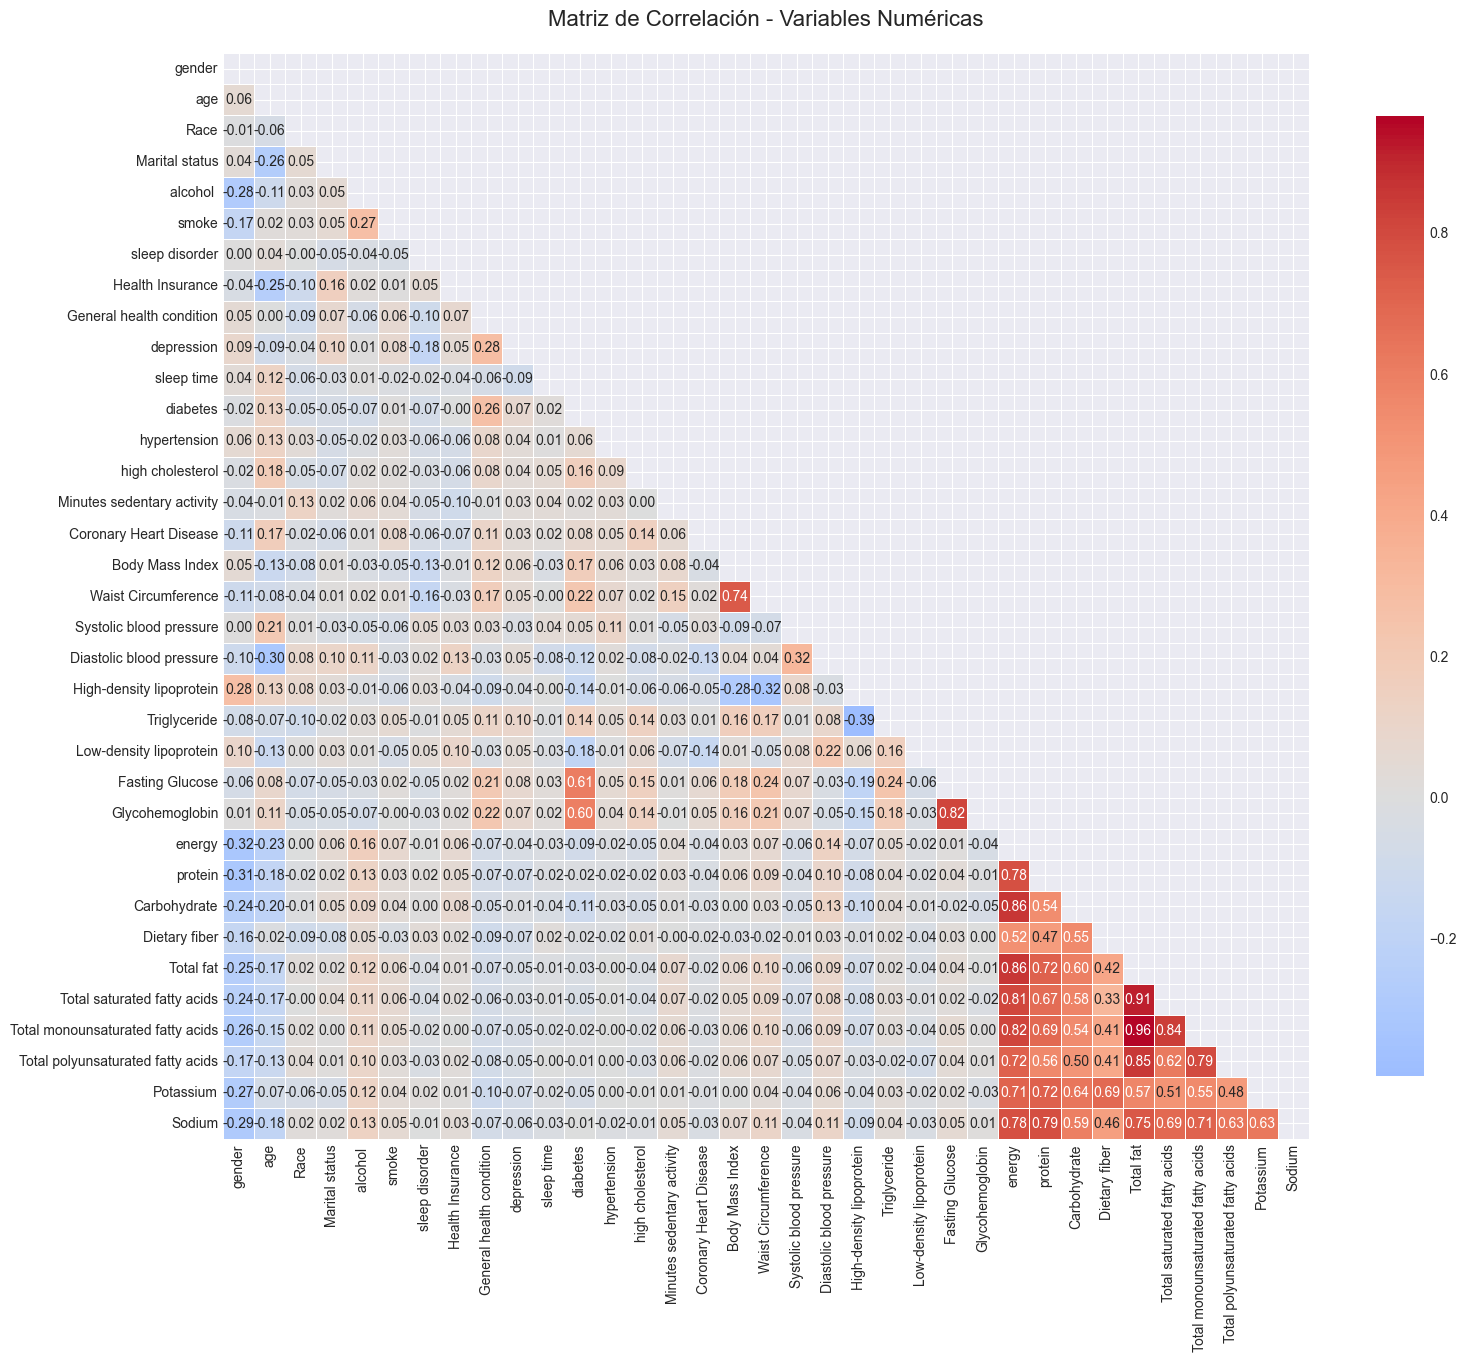


⚠ Variables con correlación alta (>0.8):
                       Var1                              Var2  Correlación
                  Total fat Total monounsaturated fatty acids        0.965
                  Total fat       Total saturated fatty acids        0.915
                     energy                         Total fat        0.863
                     energy                      Carbohydrate        0.860
                  Total fat Total polyunsaturated fatty acids        0.851
Total saturated fatty acids Total monounsaturated fatty acids        0.836
            Fasting Glucose                   Glycohemoglobin        0.818
                     energy Total monounsaturated fatty acids        0.816
                     energy       Total saturated fatty acids        0.808

Recomendación: Considerar eliminar una de cada par para evitar multicolinealidad


In [12]:
# Matriz de correlación para variables numéricas
print("=" * 60)
print("MATRIZ DE CORRELACIÓN")
print("=" * 60)

# Calcular correlación
corr_matrix = df[numeric_cols].corr()

# Visualizar matriz de correlación
plt.figure(figsize=(16, 14))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # Máscara para triángulo superior
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Matriz de Correlación - Variables Numéricas', fontsize=16, pad=20)
plt.tight_layout()
plt.show()

# Identificar correlaciones altas
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.8:
            high_corr_pairs.append({
                'Var1': corr_matrix.columns[i],
                'Var2': corr_matrix.columns[j],
                'Correlación': corr_matrix.iloc[i, j]
            })

if high_corr_pairs:
    print(f"\n⚠ Variables con correlación alta (>0.8):")
    high_corr_df = pd.DataFrame(high_corr_pairs)
    print(high_corr_df.sort_values('Correlación', key=abs, ascending=False).to_string(index=False))
    print("\nRecomendación: Considerar eliminar una de cada par para evitar multicolinealidad")
else:
    print("\n✓ No se encontraron correlaciones muy altas (>0.8)")


ANÁLISIS DE RELACIÓN CON TARGET (STROKE)

Variables numéricas - Comparación de medias:
                         Variable  Media_No_Stroke  Media_Stroke  Diferencia  P_value Significativo
                          protein           78.295        68.103     -10.192    0.000            Sí
         Diastolic blood pressure           72.772        69.746      -3.027    0.000            Sí
                           energy         2026.988      1814.481    -212.508    0.000            Sí
                           Sodium         3378.155      3010.254    -367.901    0.000            Sí
Total polyunsaturated fatty acids           18.025        15.565      -2.460    0.000            Sí
                        Potassium         2590.296      2362.202    -228.094    0.001            Sí
                        Total fat           78.425        70.136      -8.289    0.001            Sí
          Low-density lipoprotein            2.925         2.777      -0.148    0.001            Sí
Total monouns

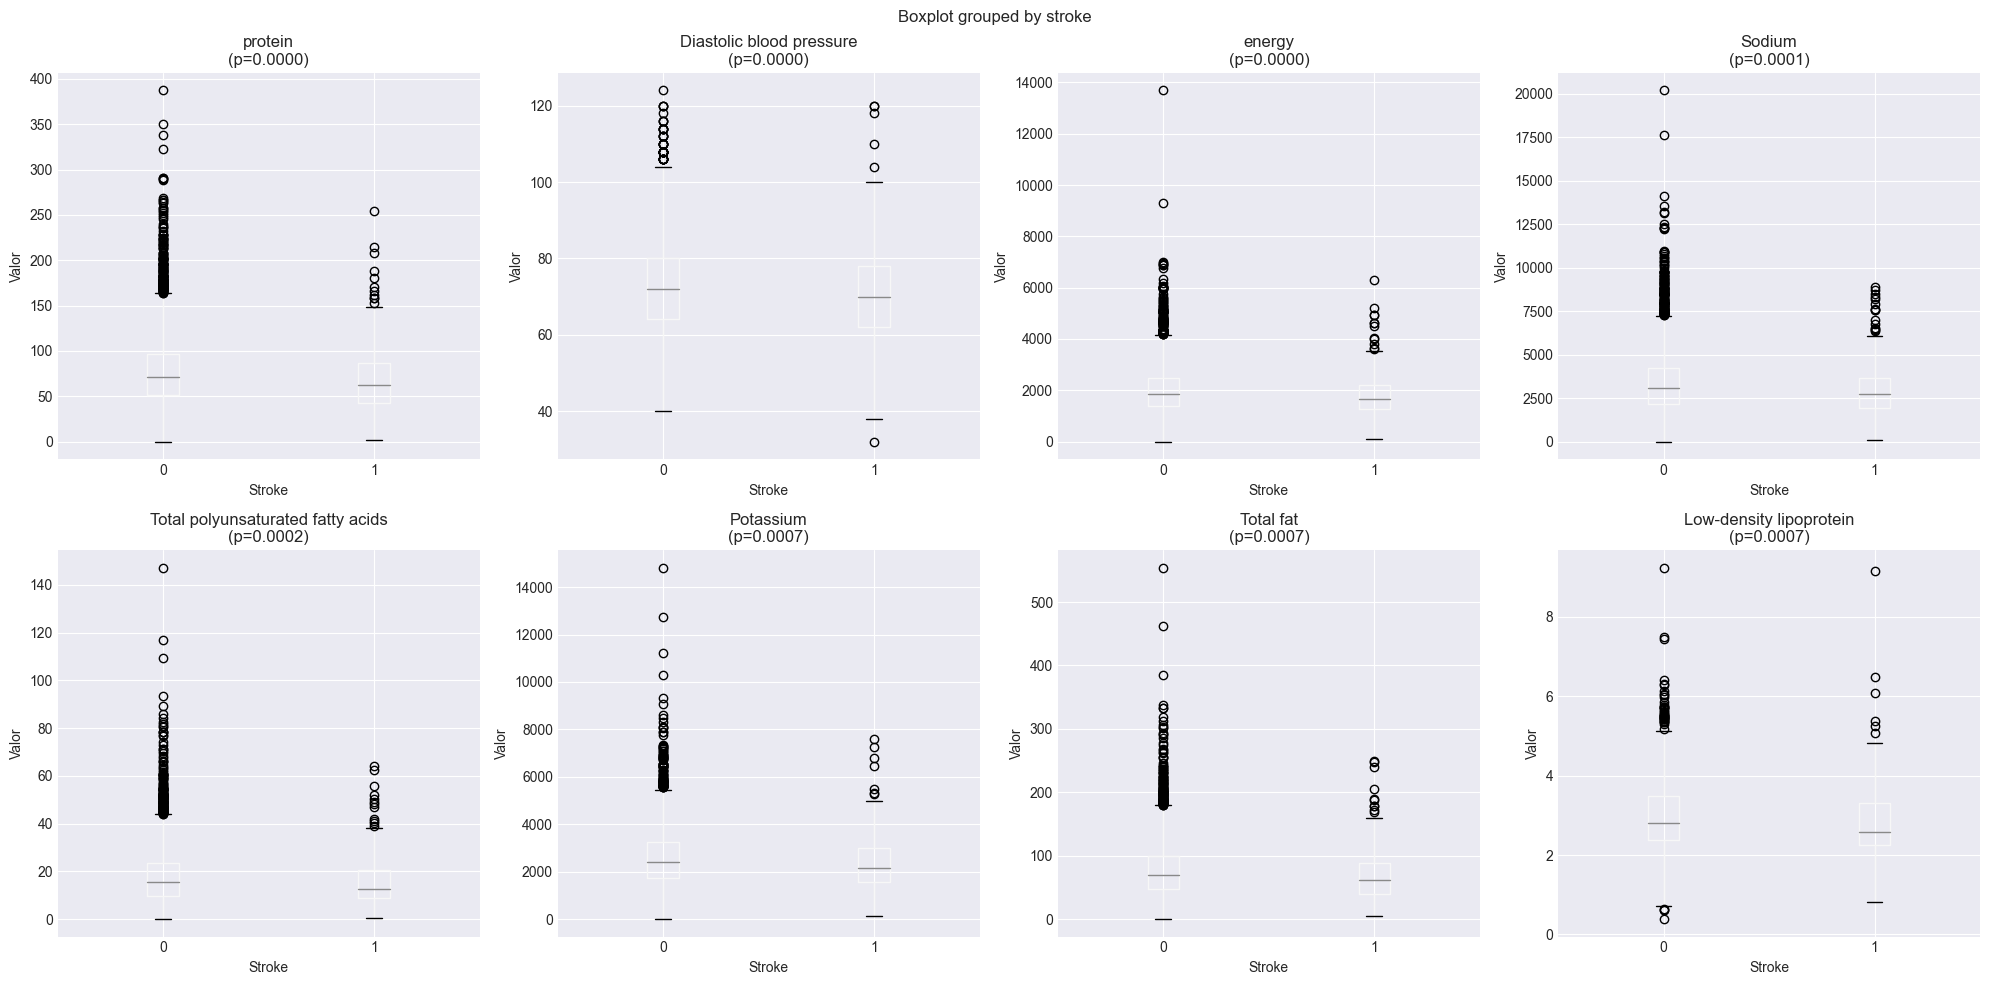

In [13]:
# Análisis de relación entre variables y target
if target_col:
    print("=" * 60)
    print("ANÁLISIS DE RELACIÓN CON TARGET (STROKE)")
    print("=" * 60)
    
    # Para variables numéricas: comparar medias por grupo
    numeric_analysis = []
    for col in numeric_cols:
        if col not in potential_categorical:
            group_0 = df[df[target_col] == 0][col].dropna()
            group_1 = df[df[target_col] == 1][col].dropna()
            
            if len(group_0) > 0 and len(group_1) > 0:
                # Test t de Student
                t_stat, p_value = stats.ttest_ind(group_0, group_1)
                
                numeric_analysis.append({
                    'Variable': col,
                    'Media_No_Stroke': group_0.mean(),
                    'Media_Stroke': group_1.mean(),
                    'Diferencia': group_1.mean() - group_0.mean(),
                    'P_value': p_value,
                    'Significativo': 'Sí' if p_value < 0.05 else 'No'
                })
    
    if numeric_analysis:
        numeric_analysis_df = pd.DataFrame(numeric_analysis)
        print("\nVariables numéricas - Comparación de medias:")
        print(numeric_analysis_df.sort_values('P_value').head(15).to_string(index=False))
        
        # Visualización de diferencias
        top_vars = numeric_analysis_df.nsmallest(8, 'P_value')['Variable'].tolist()
        fig, axes = plt.subplots(2, 4, figsize=(20, 10))
        axes = axes.flatten()
        
        for idx, col in enumerate(top_vars):
            df.boxplot(column=col, by=target_col, ax=axes[idx])
            axes[idx].set_title(f'{col}\n(p={numeric_analysis_df[numeric_analysis_df["Variable"]==col]["P_value"].values[0]:.4f})')
            axes[idx].set_xlabel('Stroke')
            axes[idx].set_ylabel('Valor')
        
        plt.tight_layout()
        plt.show()


In [14]:
# Análisis de variables categóricas vs target
if target_col:
    print("\n" + "=" * 60)
    print("ANÁLISIS DE VARIABLES CATEGÓRICAS VS TARGET")
    print("=" * 60)
    
    categorical_analysis = []
    for col in categorical_vars[:15]:  # Analizar primeras 15
        contingency_table = pd.crosstab(df[col], df[target_col])
        
        # Test Chi-cuadrado
        chi2, p_value, dof, expected = chi2_contingency(contingency_table)
        
        # Calcular proporciones
        prop_stroke = (contingency_table[1] / contingency_table.sum(axis=1) * 100).mean()
        
        categorical_analysis.append({
            'Variable': col,
            'Valores_Únicos': df[col].nunique(),
            'Chi2': chi2,
            'P_value': p_value,
            'Prop_Stroke_Media': prop_stroke,
            'Significativo': 'Sí' if p_value < 0.05 else 'No'
        })
    
    if categorical_analysis:
        cat_analysis_df = pd.DataFrame(categorical_analysis)
        print("\nVariables categóricas - Test Chi-cuadrado:")
        print(cat_analysis_df.sort_values('P_value').to_string(index=False))



ANÁLISIS DE VARIABLES CATEGÓRICAS VS TARGET

Variables categóricas - Test Chi-cuadrado:
                Variable  Valores_Únicos   Chi2  P_value  Prop_Stroke_Media Significativo
                     age               3 86.038    0.000              6.757            Sí
  Coronary Heart Disease               2 80.593    0.000             12.958            Sí
General health condition               5 68.052    0.000              7.937            Sí
                   smoke               2 17.900    0.000              7.790            Sí
          Marital status               6 28.294    0.000              8.299            Sí
              depression               3 19.560    0.000             10.347            Sí
        high cholesterol               2 15.922    0.000              7.618            Sí
                diabetes               2 14.489    0.000              8.694            Sí
            hypertension               2 12.655    0.000              6.607            Sí
        Hea

## 5. Análisis Multivariado


ANÁLISIS DE COMPONENTES PRINCIPALES (PCA)

Componentes principales: 20

Varianza explicada por los primeros componentes:
  PC1: 34.84% (Acumulado: 34.84%)
  PC2: 11.06% (Acumulado: 45.90%)
  PC3: 7.44% (Acumulado: 53.34%)
  PC4: 6.58% (Acumulado: 59.92%)
  PC5: 5.74% (Acumulado: 65.65%)
  PC6: 5.18% (Acumulado: 70.83%)
  PC7: 4.85% (Acumulado: 75.68%)
  PC8: 4.44% (Acumulado: 80.12%)
  PC9: 3.79% (Acumulado: 83.90%)
  PC10: 3.00% (Acumulado: 86.91%)


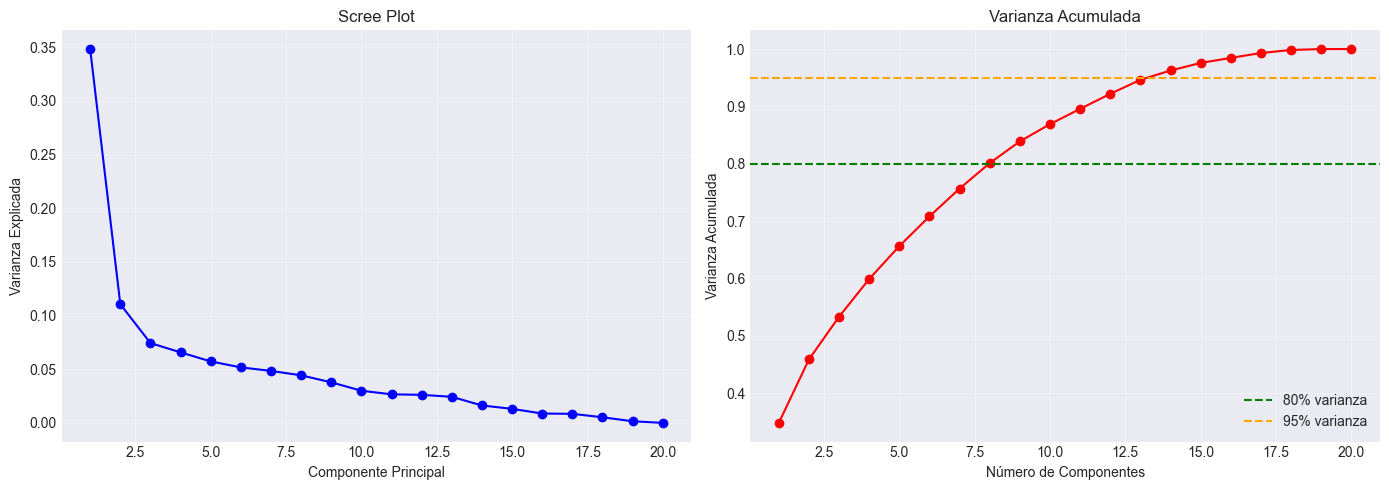


Componentes para 80% varianza: 8
Componentes para 95% varianza: 14

Recomendación: PCA puede no ser necesario


In [15]:
# Análisis de Componentes Principales (PCA) exploratorio
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

print("=" * 60)
print("ANÁLISIS DE COMPONENTES PRINCIPALES (PCA)")
print("=" * 60)

# Preparar datos para PCA (solo variables numéricas continuas)
pca_cols = [col for col in numeric_cols if col not in potential_categorical and col != target_col]
X_pca = df[pca_cols].fillna(df[pca_cols].mean())

# Estandarizar
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_pca)

# Aplicar PCA
pca = PCA()
pca.fit(X_scaled)

# Varianza explicada
explained_var = pca.explained_variance_ratio_
cumulative_var = np.cumsum(explained_var)

print(f"\nComponentes principales: {len(explained_var)}")
print(f"\nVarianza explicada por los primeros componentes:")
for i in range(min(10, len(explained_var))):
    print(f"  PC{i+1}: {explained_var[i]*100:.2f}% (Acumulado: {cumulative_var[i]*100:.2f}%)")

# Visualización
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scree plot
axes[0].plot(range(1, min(21, len(explained_var)+1)), explained_var[:20], 'bo-')
axes[0].set_xlabel('Componente Principal')
axes[0].set_ylabel('Varianza Explicada')
axes[0].set_title('Scree Plot')
axes[0].grid(alpha=0.3)

# Varianza acumulada
axes[1].plot(range(1, min(21, len(cumulative_var)+1)), cumulative_var[:20], 'ro-')
axes[1].axhline(y=0.8, color='g', linestyle='--', label='80% varianza')
axes[1].axhline(y=0.95, color='orange', linestyle='--', label='95% varianza')
axes[1].set_xlabel('Número de Componentes')
axes[1].set_ylabel('Varianza Acumulada')
axes[1].set_title('Varianza Acumulada')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Determinar número óptimo de componentes
n_components_80 = np.where(cumulative_var >= 0.80)[0][0] + 1
n_components_95 = np.where(cumulative_var >= 0.95)[0][0] + 1
print(f"\nComponentes para 80% varianza: {n_components_80}")
print(f"Componentes para 95% varianza: {n_components_95}")
print(f"\nRecomendación: {'Usar PCA puede reducir dimensionalidad' if n_components_95 < len(pca_cols) * 0.5 else 'PCA puede no ser necesario'}")


In [16]:
# Análisis de factores de riesgo conocidos para ACV
print("=" * 60)
print("ANÁLISIS DE FACTORES DE RIESGO CONOCIDOS")
print("=" * 60)

risk_factors = {
    'Hipertensión': 'hypertension' if 'hypertension' in df.columns else None,
    'Diabetes': 'diabetes' if 'diabetes' in df.columns else None,
    'Enfermedad Cardíaca': 'Coronary Heart Disease' if 'Coronary Heart Disease' in df.columns else None,
    'Colesterol Alto': 'high cholesterol' if 'high cholesterol' in df.columns else None,
    'Tabaquismo': 'smoke' if 'smoke' in df.columns else None,
    'Edad': 'age' if 'age' in df.columns else None,
    'IMC': 'Body Mass Index' if 'Body Mass Index' in df.columns else None
}

if target_col:
    print("\nPrevalencia de factores de riesgo en casos con stroke:")
    for factor_name, factor_col in risk_factors.items():
        if factor_col and factor_col in df.columns:
            if df[factor_col].dtype in ['int64', 'float64']:
                if df[factor_col].nunique() < 10:  # Variable categórica codificada
                    stroke_with_factor = df[(df[target_col] == 1) & (df[factor_col] == 1)].shape[0]
                    total_stroke = df[target_col].sum()
                    if total_stroke > 0:
                        pct = (stroke_with_factor / total_stroke) * 100
                        print(f"  {factor_name}: {pct:.1f}% de casos con stroke tienen {factor_name}")
                else:  # Variable numérica
                    stroke_mean = df[df[target_col] == 1][factor_col].mean()
                    no_stroke_mean = df[df[target_col] == 0][factor_col].mean()
                    print(f"  {factor_name}: Media en stroke={stroke_mean:.2f}, No stroke={no_stroke_mean:.2f}")


ANÁLISIS DE FACTORES DE RIESGO CONOCIDOS

Prevalencia de factores de riesgo en casos con stroke:
  Hipertensión: 89.8% de casos con stroke tienen Hipertensión
  Diabetes: 34.8% de casos con stroke tienen Diabetes
  Enfermedad Cardíaca: 22.4% de casos con stroke tienen Enfermedad Cardíaca
  Colesterol Alto: 67.7% de casos con stroke tienen Colesterol Alto
  Tabaquismo: 63.0% de casos con stroke tienen Tabaquismo
  Edad: 3.0% de casos con stroke tienen Edad
  IMC: 1.4% de casos con stroke tienen IMC


## 7. Conclusiones y Recomendaciones


### Resumen de Hallazgos Clave:

1. **Calidad de Datos:**
   - [Completar basado en análisis de valores faltantes]
   - [Completar basado en análisis de duplicados]
   - [Completar basado en análisis de outliers]

2. **Balance del Dataset:**
   - [Completar ratio de desbalance]
   - [Recomendación de técnicas de balanceo]

3. **Variables Más Importantes:**
   - [Listar top 5-10 variables más correlacionadas con target]
   - [Listar variables con mayor significancia estadística]

4. **Multicolinealidad:**
   - [Listar pares de variables altamente correlacionadas]
   - [Recomendación de variables a eliminar]

5. **Preprocesamiento Necesario:**
   - Manejo de valores faltantes: [Estrategia recomendada]
   - Manejo de outliers: [Estrategia recomendada]
   - Normalización/Estandarización: [Recomendación]
   - Encoding categóricas: [Recomendación]

6. **Recomendaciones para Modelado:**
   - Técnicas de balanceo: [SMOTE, ADASYN, etc.]
   - Validación: [Stratified K-Fold CV recomendado]
   - Métricas prioritarias: [Recall, F1, AUC-ROC, AUC-PR]
   - Uso de PCA: [Sí/No y número de componentes]


In [17]:
# Generar resumen ejecutivo
print("=" * 60)
print("RESUMEN EJECUTIVO DEL EDA")
print("=" * 60)

summary = {
    'Total de muestras': len(df),
    'Total de variables': len(df.columns),
    'Variables numéricas': len(numeric_cols),
    'Variables categóricas': len(categorical_vars),
    'Valores faltantes': df.isnull().sum().sum(),
    'Filas duplicadas': df.duplicated().sum()
}

if target_col:
    target_dist = df[target_col].value_counts()
    summary['Casos sin stroke'] = target_dist.get(0, 0)
    summary['Casos con stroke'] = target_dist.get(1, 0)
    if len(target_dist) > 1:
        summary['Ratio de desbalance'] = f"{target_dist[0]/target_dist[1]:.2f}:1"

for key, value in summary.items():
    print(f"{key}: {value}")

print("\n✓ Análisis Exploratorio de Datos completado")
print("✓ Revisar secciones anteriores para detalles específicos")


RESUMEN EJECUTIVO DEL EDA
Total de muestras: 4603
Total de variables: 36
Variables numéricas: 35
Variables categóricas: 15
Valores faltantes: 0
Filas duplicadas: 0
Casos sin stroke: 4241
Casos con stroke: 362
Ratio de desbalance: 11.72:1

✓ Análisis Exploratorio de Datos completado
✓ Revisar secciones anteriores para detalles específicos
